In [48]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import os

from warnings import filterwarnings
filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [49]:
#load the data
data = pd.read_csv('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\ahdt.csv')

In [50]:
#df = data[(data['plaza_id'] == '30') & (data['direction'] == 'I') ]
df = data[(data['plaza_id'] == 25) & (data['direction'] == 'I')]

In [51]:
df['total'] = df['vehicles_etc_e_zpass'] + df['vehicles_cash_vtoll']

In [52]:
df['date'] =  pd.to_datetime(df['date'])

In [53]:
# sort Date and Hour - descending order
df.sort_values(by=['date', 'hour'], inplace=True, ascending=[True, True])

In [54]:
df['drange'] = pd.date_range(start ='2019-01-01 00:00:00', periods = len(df), freq='H') 

In [55]:
# Drop unnecessory columns ['plaza_id', 'date', 'hour', 'direction', 'vehicles_etc_e_zpass', 'vehicles_cash_vtoll']
df = df.drop(columns =['plaza_id', 'date', 'hour', 'direction', 'vehicles_etc_e_zpass', 'vehicles_cash_vtoll']) 

In [56]:
# set drange column as index
df = df.set_index('drange')
df.index = pd.to_datetime(df.index)

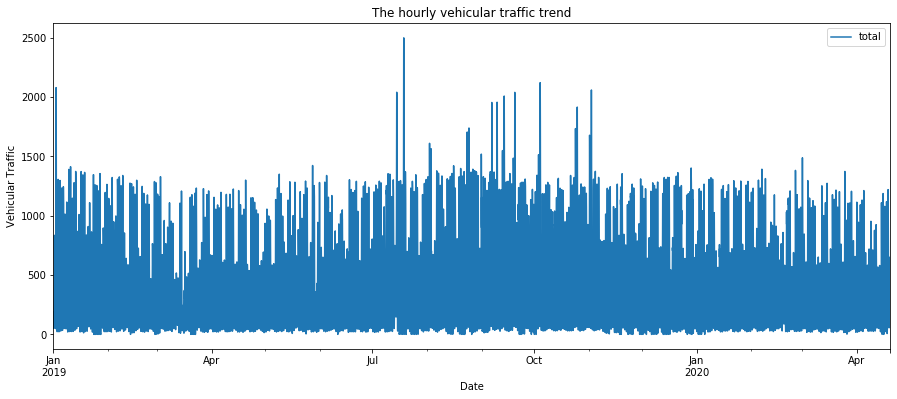

In [57]:
# Plot the dataframe to visualize time series data
df.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()

In [58]:
# Convert dataframe into Numpy array
data_copy = df.copy()
df = df.values

In [64]:
df[:5]

array([[190],
       [112],
       [ 72],
       [ 62],
       [ 52]], dtype=int64)

In [65]:
# Perform feature scaling of data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

df = scaler.fit_transform(df)

# Divide data into 80% training and 20% testing
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

In [68]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [96]:
X_test[-1]

array([0.44052863, 0.37645174, 0.3031638 , 0.24309171, 0.17901482,
       0.1670004 , 0.13976772, 0.10372447, 0.06968362, 0.04084902,
       0.03043652, 0.02362835, 0.02202643, 0.03484181, 0.04485382,
       0.06247497, 0.10212255, 0.1093312 , 0.15378454, 0.23828594,
       0.22987585, 0.2206648 , 0.20344413, 0.20945134, 0.26071286,
       0.18261914, 0.20224269, 0.18261914, 0.14497397, 0.13175811])

In [81]:
X_train[4]

array([0.02042451, 0.02202643, 0.04205046, 0.04645575, 0.07168602,
       0.08970765, 0.12935523, 0.17220665, 0.24028835, 0.27152583,
       0.3340008 , 0.29915899, 0.27352823, 0.22987585, 0.20664798,
       0.17661193, 0.16659992, 0.13776532, 0.11013216, 0.08690429,
       0.06928314, 0.0392471 , 0.03203845, 0.02963556, 0.01962355,
       0.03043652, 0.05726872, 0.07609131, 0.15378454, 0.30957149])

In [76]:
Y_train

array([0.05726872, 0.07609131, 0.15378454, ..., 0.16659992, 0.16179415,
       0.17180617])

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error: {:.4f}'.format(mean_absolute_error(Y_train[0], train_predict[:,0])))
print('Train Root Mean Squared Error: {:.4f}'.format(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))))
print('Test Mean Absolute Error: {:.4f}'.format(mean_absolute_error(Y_test[0], test_predict[:,0])))
print('Test Root Mean Squared Error: {:.4f}'.format(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))))

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
ax = [x for x in range(len(test_predict))]
plt.figure(figsize = (14,6))
plt.plot(ax, Y_test[0][:len(test_predict)], marker='.', label='Actual Traffic')
plt.plot(ax, test_predict[:,0][:len(test_predict)], 'r', label='Predicted Traffic')
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Hourly Vehicular Traffic', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Create a blank dataframe with date range same as X_test
drange_predict = pd.date_range(end ='2020-04-20 01:00:00', periods = len(X_test), freq='H') 

In [ ]:
df_predict = pd.DataFrame(index=drange_predict, data=test_predict)

In [ ]:
# Plot the dataframe to visualize time series data
plt.figure(figsize=(18,6))
plt.plot(data_copy.iloc[-5000:])
plt.plot(df_predict)
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()

In [ ]:
# Save the model using keras
model.save('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\timeseriesmodel_lstm.h5')

In [ ]:
# Import libraries to load the model using keras
from keras.models import load_model

# load model
model_new = load_model('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\timeseriesmodel_lstm.h5')

# Summarize model
model_new.summary()

### Forecast for 3 weeks i.e. 336 hours

In [37]:
# Create date range for 3 weeks to forecast
drange_forecast = pd.date_range(start ='2020-04-20 01:00:00', periods = 336, freq='H')

In [40]:
drange_forecast = drange_forecast.values

In [211]:
def forecast_values(scaler, periods, test, model):
    forecast_list = []
    X_forecast = test[-30:]
    
    for i in range(periods):
        X_forecast = np.reshape(X_forecast[-30:], (1, 1, len(X_forecast[-30:])))
        forecast_values = model.predict(X_forecast)
        true_forecast = scaler.inverse_transform(forecast_values)
        forecast_list = np.append(forecast_list, true_forecast)
        X_forecast = np.append(X_forecast, forecast_values)
        
        
    return forecast_list    

In [222]:
forecast = forecast_values(scaler, 30, test, model)

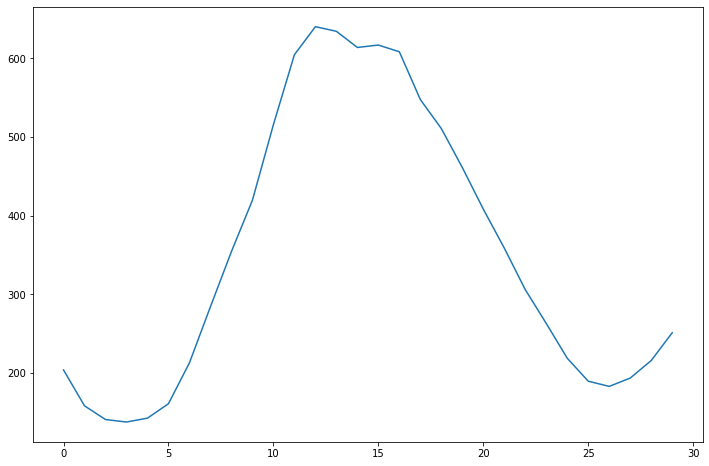

In [223]:
plt.plot(forecast)

In [ ]:
forecast = []
X_forecast = test[-30:]    
for i in range(5):
    X_forecast = np.reshape(X_forecast[-30:], (1, 1, len(X_forecast[-30:])))
    forecast_values = model.predict(X_forecast)
    X_forecast = np.append(X_forecast, forecast_values)
    print(X_forecast)

print(X_forecast)